In [1]:
import torch

In [2]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image
import torchvision
import pathlib
import numpy as np
import cv2
import os
import random
import glob
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
transformer = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
# DIRECTORY = r"G:\CSE_465\project\project\Dataset"
# CATEGORIES = ['Bear','Camel','Cat','Dear','Dog','Elephant','Fish','Hamstar','Rakun','Tiger']
# Number_inside = ['n02132136','n02437312','n02124075','n02423022','n02099712','n02504458','n01443537','n02364673','n02509815','n02125311']

In [6]:
# data=[]

# for categories in CATEGORIES :
#     folder = os.path.join(DIRECTORY, categories)
#     label = CATEGORIES.index(categories)
    
#     for img in os.listdir(folder):
#         image = os.path.join(folder, img)
#         image_arr = cv2.imread(image)
#         data.append([image_arr, label])

In [7]:
# random.shuffle(data)

In [8]:
# data

In [9]:
# X=[]
# y=[]

# for feature, label in data:
#     X.append(feature)
#     y.append(label)
    


In [10]:
# X =  np.array(X)
# y =  np.array(y)

# X = X/255

In [11]:
# X.shape

In [142]:
train_path = r'G:\CSE_465\project\project\Dataset'
tests_path = r'G:\CSE_465\project\project\test'

train_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform = transformer),
    batch_size = 100,shuffle= True
)

test_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(tests_path, transform = transformer),
    batch_size = 100,shuffle= True
)

In [143]:
# root=pathlib.Path(train_path)
# classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
# print(classes)


In [144]:
classes = ['Bear','Camel','Cat','Dear','Dog','Elephant','Fish','Hamstar','Rakun','Tiger']

torch.Size([100, 3, 64, 64]) torch.Size([100])


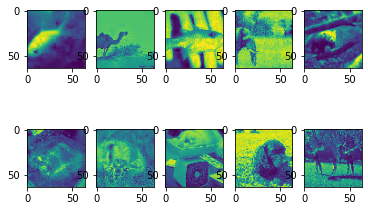

10


In [145]:
example = iter(train_dataloader)
samples, labels = example.next()
print(samples.shape, labels.shape)
for i in range(10):
    plt.subplot(2,5, i+1)
    plt.imshow(samples[i][0])
plt.show()
print(len(train_dataloader))

In [99]:
class FeedForward(torch.nn.Module):
    def __init__(self, input_size, hidden_size, numclasses):
        super(FeedForward, self).__init__()
        self.l1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(hidden_size,numclasses)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out


In [ ]:
model = FeedForward((3*64*64), 100, 10)
model = model.to(device)
epoch = 100


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_total_stapes = len(train_dataloader)
for  epochs in range(epoch):
    model.train()
    train_loss = 0.0
    train_accuricy = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.reshape(-1, (3*64*64)).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data*10
        
        _,prediction = torch.max(outputs.data,1)
        
        train_accuricy+= int(torch.sum(prediction==labels.data))
        
    train_accuricy = train_accuricy/1000
    train_loss = train_loss/1000
    
    
    model.eval()
    test_accuricy= 0.0
    
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.reshape(-1, (3*64*64)).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _,prediction = torch.max(outputs.data,1)
        
        test_accuricy+= int(torch.sum(prediction==labels.data))
        
    test_accuricy = test_accuricy/500
    print(f'Epoch {epochs+1} / {epoch} , Train Loss: {train_loss:.4f},  Train Accuricy:  {train_accuracy:.4f},   Test Accuricy:  {test_accuricy:.4f}' )   



Epoch 1 / 100 , Train Loss: 0.2820,  Train Accuricy:  0.1180,   Test Accuricy:  0.1600
Epoch 2 / 100 , Train Loss: 0.2339,  Train Accuricy:  0.1180,   Test Accuricy:  0.1640
Epoch 3 / 100 , Train Loss: 0.2170,  Train Accuricy:  0.1180,   Test Accuricy:  0.2100
Epoch 4 / 100 , Train Loss: 0.2115,  Train Accuricy:  0.1180,   Test Accuricy:  0.2020
Epoch 5 / 100 , Train Loss: 0.2042,  Train Accuricy:  0.1180,   Test Accuricy:  0.2680
Epoch 6 / 100 , Train Loss: 0.1982,  Train Accuricy:  0.1180,   Test Accuricy:  0.2220
Epoch 7 / 100 , Train Loss: 0.1941,  Train Accuricy:  0.1180,   Test Accuricy:  0.2480
Epoch 8 / 100 , Train Loss: 0.1913,  Train Accuricy:  0.1180,   Test Accuricy:  0.2580
Epoch 9 / 100 , Train Loss: 0.1860,  Train Accuricy:  0.1180,   Test Accuricy:  0.2540
Epoch 10 / 100 , Train Loss: 0.1850,  Train Accuricy:  0.1180,   Test Accuricy:  0.2520
Epoch 11 / 100 , Train Loss: 0.1834,  Train Accuricy:  0.1180,   Test Accuricy:  0.2740
Epoch 12 / 100 , Train Loss: 0.1764,  Tra

In [90]:
def Prediction(image_path , transformer):
    image = Image.open(image_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.reshape(-1,(3*64*64))
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor.to(device)
       
        
    input = Variable(image_tensor).to(device)

    output = model(input)
    output = output.cpu()
    index = output.data.numpy().argmax()
    
    pred = classes[index]
    
    return pred


In [141]:
# test_img_path = glob.glob(pred_path+'/*.JPEG')
# # print(test_img_path)
# pred_dict={}
# # for i in test_img_path:
# #     pred_dict[i[i.rfind('/')+1:]]=Prediction(i, transformer)
# #     print(i)
Prediction("G:/CSE_465/project/project/n02504458_343.JPEG", transformer)

'Elephant'

In [20]:
# pred_dict

In [21]:
# image = Image.open("G:/CSE_465/project/project/test/n02437312_292.JPEG")
# image = transformer(image)
# image = image.reshape(-1,(3*64*64))
# print(image.shape)

In [43]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batch_size = 4
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
